### Trabalho Prático de IeC

**Objetivo** : Procurar um numero N em uma lista não ordenada, utilizando um algoritmo quantico. Dos algoritmos dados na aula, o algoritmo de groover é o mais adequado para efetuar a procura.

A implementação do algoritmo de Grover é feito em 3 fases:
* Inicialização
* Oraculo
* Amplificação

     Preparação Quiskit:

In [7]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

 **Inicialização :**
         Determinar o numero a ser procurado, e a sua representação binária:

In [8]:
N = 14
w = N % 8
wb = bin(w)[2:]
print(w)
print(wb)

6
110


Selecionamos o número de qubits necessários para representar o número binário que nos foi dado. Neste caso são precisos 3 qbits.


In [9]:
x=3

**Oraculo** : Criação do oraculo.

*Decomposição CnZ*


In [10]:
def decompose_CnZ(circuit, qr_x, qr_a): 
    circuit.ccx(qr_x[0],qr_x[1],qr_a[0])
    
    for i in range(2, x-1):
        circuit.ccx(qr_x[i],qr_a[i-2],qr_a[i-1])
    
    circuit.cz(qr_a[x-3], qr_x[x-1])
    
    for i in range(x-2, 1, -1):
        circuit.ccx(qr_x[i],qr_a[i-2],qr_a[i-1])
    
    circuit.ccx(qr_x[0],qr_x[1],qr_a[0])

In [11]:
qr_a= QuantumRegister(x-2,'qr_aux')

In [12]:
qr_x = QuantumRegister(x, 'x')

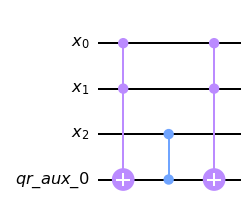

In [13]:
qc_help5= QuantumCircuit(qr_x, qr_a)
decompose_CnZ(qc_help5, qr_x, qr_a)

qc_help5.draw(output='mpl')

In [14]:
def select_w(circuit, qr_x):
    circuit.x(qr_x[0])
    #circuit.x(qr_x[1])
    #circuit.x(qr_x[2])

def phase_oracle(circuit, qr_x, qr_a):
    select_w(circuit,qr_x)
    decompose_CnZ(circuit, qr_x, qr_a)
    select_w(circuit,qr_x)

**Diffusor** 

O Objetivo do difusor é de inverter a fase do input desejado, assim como ampliar a sua amplitude.

In [15]:
def diffuser(circuit, qr_x, qr_a):
    circuit.h(qr_x)
    circuit.x(qr_x)
    decompose_CnZ(circuit, qr_x, qr_a) #CCCCZ -> CCZ
    circuit.x(qr_x)
    circuit.h(qr_x)

Agora vamos calcular o numero de vezes que temos de repetir a execução do oráculo e do difusor. Este valor (x) é determinado por x = $\sqrt{N}$ , sendo N o comprimento da lista de entrada (Numero de elementos). Este valor é o numero ideal de "iterações" para ter um bom valor de medição, sem degradação dos resultados.

In [16]:
import math as m

times= round(m.sqrt(2**x))
print(times)

3


Nesta fase vamos fazer a medição dos qubits.

In [17]:
backend = Aer.get_backend("qasm_simulator")

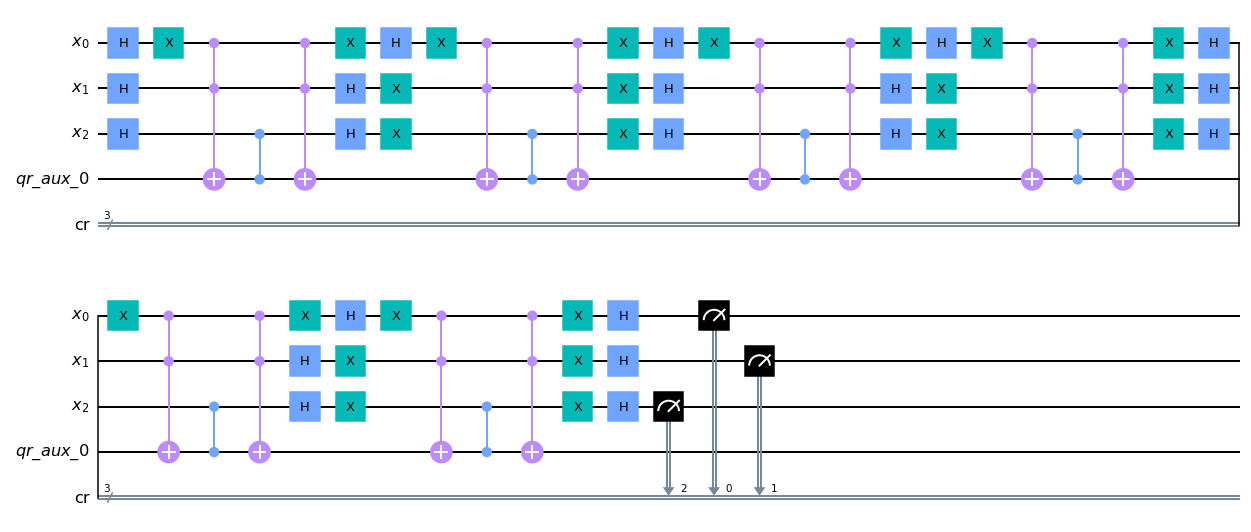

In [40]:
cr=ClassicalRegister(x,'cr')
qc_Grover= QuantumCircuit(qr_x,qr_a,cr)

# 1.init
qc_Grover.h(qr_x)

# 2.oracle and diffuser 

for t in range(times):
    # a)
    phase_oracle(qc_Grover, qr_x,qr_a)
    # b)
    diffuser(qc_Grover,qr_x,qr_a)

# 3.     
qc_Grover.measure(qr_x,cr)

qc_Grover.draw(output='mpl')

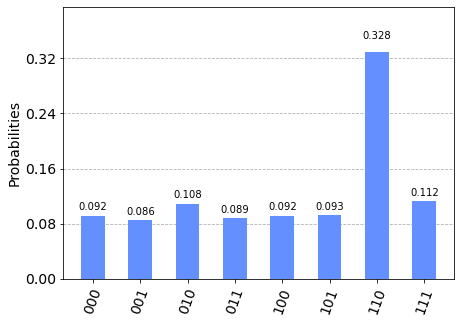

In [41]:
shots=1024
result = execute(qc_Grover, backend, shots=shots).result()
counts_sim = result.get_counts(qc_Grover)
plot_histogram(counts_sim)

In [37]:
qc_Grover.depth()

14

Nesta fase vamos correr o algoritmo num **Computador quântico**.

In [14]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [15]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [16]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 2              Pending Jobs: 9              Pending Jobs: 0
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      151.0          Avg. T1:      75.2           Avg. T1:      79.3
Avg. T2:      67.0           Avg. T2:      73.2           Avg. T2:      91.6



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 7              Pending Jobs: 4              Pending Jobs: 1
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operatio

In [17]:
backend_device = provider.get_backend('ibmq_16_melbourne')
print("Running on: ", backend_device)

Running on:  ibmq_16_melbourne


In [18]:
# See backend information
backend_device

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>

In [19]:
backend_monitor(backend_device)

ibmq_16_melbourne
Configuration
-------------
    n_qubits: 15
    operational: True
    status_msg: active
    pending_jobs: 0
    backend_version: 2.3.24
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx']
    local: False
    simulator: False
    supported_instructions: ['cx', 'id', 'delay', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
    n_registers: 1
    online_date: 2018-11-06 05:00:00+00:00
    pulse_num_qubits: 3
    conditional: False
    credits_required: True
    coupling_map: [[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 12], [3, 2], [3, 4], [3, 11], [4, 3], [4, 5], [4, 10], [5, 4], [5, 6], [5, 9], [6, 5], [6, 8], [7, 8], [8, 6], [8, 7], [8, 9], [9, 5], [9, 8], [9, 10], [10, 4], [10, 9], [10, 11], [11, 3], [11, 10], [11, 12], [12, 2], [12, 11], [12, 13], [13, 1], [13, 12], [13, 14], [14, 0], [14, 13]]
    allow_q_object: True
    dtm: 0.2222222222222222
    description: 15 qubit device
    memory: True
    quantum_volume: 8
    max_shots: 8192
    backend_nam

In [20]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [21]:
job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bb8c6300aded9c926a6e71


In [22]:
#ibmq_16_melbourne 4 times the oracle:
job_get=backend_device.retrieve_job("60bb8c6300aded9c926a6e71")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

In [24]:
#ibmq_16_melbourne 1 times the oracle:
job_get=backend_device.retrieve_job("60bb8c6300aded9c926a6e71")

result_r = job_get.result()
counts_run = result_r.get_counts()

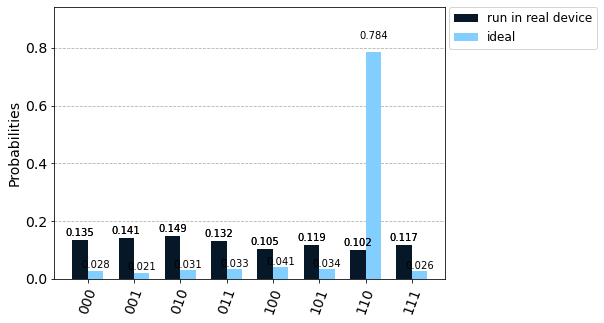

In [25]:
plot_histogram([counts_run, counts_sim ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

Agora vamos atenuar os erros com o **Ignis**

In [26]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

### Calibration Matrices

**1** Vamos criar uma list com os circuitos de calibração da medição.

Cada circuito cria um estado de base.

Como medimos 3 qubits, precisamos de $2^3 = 8$ circuitos de calibração.

In [27]:
# Generate the calibration circuits
qr = QuantumRegister(x)

# meas_calibs:
# list of quantum circuit objects containing the calibration circuits
# state_labels:
# calibration state labels
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [28]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

#### Computação da matriz de calibração

Se não houvesse ruído no dispositivo, a matriz de calibração seria a matriz de identidade $8 \times 8$. Uma vez que calculamos esta matriz com um dispositivo quântico real, vai haver algum ruído.

Podíamos fazer este passo com um ruído simulado do Qiskit Aer.

In [30]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bb8de3fe8ff1941529e7f6


In [31]:
job_get=backend_device.retrieve_job("60bb8de3fe8ff1941529e7f6")

cal_results = job_get.result()

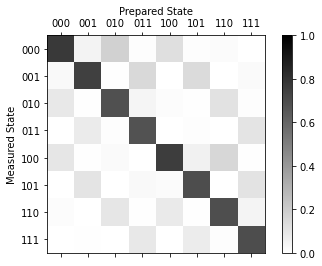

In [32]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

#### Análise dos resultados

In [33]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.715454


### Aplicar a Calibração

Vamos agora aplicar um filtro baseado na matriz de calibração para obter contagens atenuadas.

In [34]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

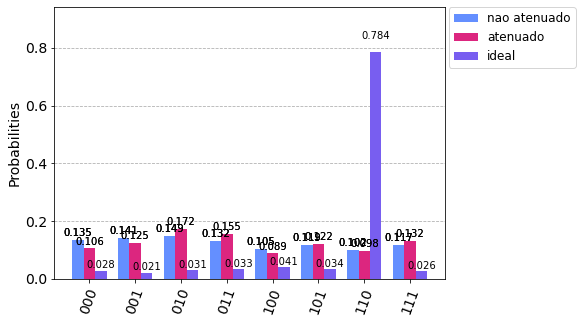

In [38]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['nao atenuado', 'atenuado', 'ideal'])